In [1]:
import os

import folium
import geojson
import pandas as pd
from IPython.display import Image
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from geopy.geocoders import GoogleV3, Nominatim
from shapely.geometry import shape, Point

In [2]:
load_dotenv()
GOOGLE_GEO_API_KEY = os.environ.get('GOOGLE_GEO_API_KEY')

## Parse flat price, size, address from saved html pages

In [3]:
def find_flat_in_minsk() -> list:
    _flats = []

    for page_number in range(1, 26):
        html_page_name = 'flat/%s.html' % page_number
        with open(html_page_name) as html_file:
            soup = BeautifulSoup(html_file, 'html.parser')

        prices = soup.find_all('span', attrs={'data-bind': "text: SearchApartments.formatPrice(apartment.price, 'USD')"})

        flats = soup.find_all('span', attrs={'class': 'classified__caption-item classified__caption-item_type', 
                                             'data-bind': 'text: SearchApartments.formatRentType(apartment.rent_type)'})

        addresses = soup.find_all('span', attrs={'class': 'classified__caption-item classified__caption-item_adress', 
                                                 'data-bind': 'text: apartment.location.user_address'})

        # print(page_number, '| prices:', len(prices), ', flats:', len(flats), ', addresses', len(addresses), '\n')

        for price, flat_size, address in zip(prices, flats, addresses):
            pr = int(price.text)
            fs = flat_size.text
            if fs == 'Комната':
                fs = 0.5
            else:
                fs = int(fs[0])

            ads = address.text

            _flats.append([pr, fs, ads])
    
    return _flats

In [4]:
# minsk_flats = find_flat_in_minsk()
# print('Now avalible', len(minsk_flats), 'flats in Minsk')
# minsk_flats[:5]

Now avalible 900 flats in Minsk


[[295, 1, 'Чернышевского, 7'],
 [900, 4, 'Калинина, 7А'],
 [470, 2, 'Мельникайте, 16'],
 [380, 1, 'Академика Фёдорова, 3'],
 [300, 2, 'Волоха, 7 к1']]

## Find coordinates for each flat with Google GEO API, and add them to the list (minsk_flats)

In [5]:
def find_coords(flat_list: list):
    for flat in flat_list:
        try:
            address = flat[2] + ', Minsk'
            google_geo = GoogleV3(api_key=GOOGLE_GEO_API_KEY)
            coords = google_geo.geocode(address)

            lat = round(float(coords.latitude), 7)
            lng = round(float(coords.longitude), 7)

            flat.append(lat)
            flat.append(lng)
            # print(lat, lng)
        except Exception as ex:
            print('Exception in google_location: %s' % ex)

In [6]:
# find_coords(minsk_flats)
# minsk_flats[:5]

[[295, 1, 'Чернышевского, 7', 53.9269839, 27.6004055],
 [900, 4, 'Калинина, 7А', 53.9264201, 27.6057458],
 [470, 2, 'Мельникайте, 16', 53.9096188, 27.5449777],
 [380, 1, 'Академика Фёдорова, 3', 53.8729582, 27.6332679],
 [300, 2, 'Волоха, 7 к1', 53.8969071, 27.5218413]]

## Save parsed data to csv

In [7]:
# columns = ['price', 'flat-size', 'address', 'lat', 'lng']
# df_flats = pd.DataFrame(data=minsk_flats, columns=columns)
# df_flats.head()

In [8]:
# df_flats.to_csv('datas/minsk_flats.csv')

### open csv

In [9]:
df_flats = pd.read_csv('datas/minsk_flats.csv')
df_flats.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
print(df_flats.shape)
df_flats.head()

(911, 5)


,price,flat-size,address,lat,lng
0,295,1.0,"Чернышевского, 7",53.926984,27.600406
1,900,4.0,"Калинина, 7А",53.926420,27.605746
2,470,2.0,"Мельникайте, 16",53.909619,27.544978
3,380,1.0,"Академика Фёдорова, 3",53.872958,27.633268
4,300,2.0,"Волоха, 7 к1",53.896907,27.521841


## for df_flats add 1 column 'aria'

In [10]:
len_df_flats = df_flats.shape[0]
len_df_flats

911

In [11]:
df_a = pd.DataFrame(data=[None for _ in range(len_df_flats)], columns=['area'])
df_flats = pd.concat([df_flats, df_a], axis=1)
df_flats.head()

,price,flat-size,address,lat,lng,area
0,295,1.0,"Чернышевского, 7",53.926984,27.600406,None
1,900,4.0,"Калинина, 7А",53.926420,27.605746,None
2,470,2.0,"Мельникайте, 16",53.909619,27.544978,None
3,380,1.0,"Академика Фёдорова, 3",53.872958,27.633268,None
4,300,2.0,"Волоха, 7 к1",53.896907,27.521841,None


## for each flat find neighborhood from geojson polygons

In [12]:
minsk_areas = r'datas/minsk_areas.geojson'

In [13]:
def open_geojson():
    with open(minsk_areas, encoding="utf8") as f:
        data = geojson.load(f)
    
    point = Point(27.429495, 53.912448)
    
    for index in range(len_df_flats):
        flat_lat = df_flats.iloc[index, 3]
        flat_lng = df_flats.iloc[index, 4]

        for feature_t in data['features']:
            point = Point(flat_lng, flat_lat)
            polygon = shape(feature_t['geometry'])
            
            if polygon.contains(point):
                neighborhood = feature_t['properties']['neighborhood']
                # print('Found containing polygon:', neighborhood)
                df_flats.at[index, 'area'] = neighborhood


In [ ]:
%%time
open_geojson()

In [28]:
df_flats

,price,flat-size,address,lat,lng,area
0,295,1.0,"Чернышевского, 7",53.926984,27.600406,None
1,900,4.0,"Калинина, 7А",53.926420,27.605746,Челюскинтцев
2,470,2.0,"Мельникайте, 16",53.909619,27.544978,Центр
3,380,1.0,"Академика Фёдорова, 3",53.872958,27.633268,западный посёлок
4,300,2.0,"Волоха, 7 к1",53.896907,27.521841,Розы люксембург
...,...,...,...,...,...,...
906,420,1.0,Леонардо да Винчи 2,53.952598,27.665858,новая боровая
907,399,2.0,Леонардо да Винчи 2,53.952598,27.665858,новая боровая
908,380,2.0,"Копищи, Николая Михайлашева 2",53.959410,27.669652,копище
909,1200,6.0,Валерьяново,53.969241,27.661743,Валерьяново


### Check if every flat has assigned neighborhood

In [15]:
df_flats.isnull().sum()

price         0
flat-size     0
address       0
lat           0
lng           0
area         54
dtype: int64

### group dataframe by neighborhood

In [16]:
areas_grouped = df_flats.groupby('area').mean().reset_index()
print(areas_grouped.shape)
areas_grouped.head()

(68, 5)


,area,price,flat-size,lat,lng
0,Академии наук,818.000000,2.500000,53.923316,27.599986
1,Аэродромная,417.128205,1.858974,53.878716,27.548024
2,Брилевичи,424.545455,1.636364,53.851028,27.484192
3,Валерьяново,1200.000000,6.000000,53.969241,27.661743
4,Велозавод,140.000000,0.500000,53.885515,27.587505


## Normalize flat price -> x $ / 1 room

In [17]:
avg_price = round(areas_grouped['price'].div(areas_grouped['flat-size']), 1)
flat_norm = pd.concat([areas_grouped['area'], avg_price], axis=1)
flat_norm.columns = ['area', 'avg-price']
flat_norm.head()

,area,avg-price
0,Академии наук,327.2
1,Аэродромная,224.4
2,Брилевичи,259.4
3,Валерьяново,200.0
4,Велозавод,280.0


In [18]:
# flat_norm.to_csv('datas/flat_norm.csv')

## Plot result (display map) - average flat price in Minsk per neighborhood

In [19]:
address = 'Minsk, BY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Minsk are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Minsk are 53.902334, 27.5618791.


In [20]:
map_minsk_flat = folium.Map(location=[latitude, longitude], zoom_start=12)

choropleth = folium.Choropleth(
    geo_data=minsk_areas,    # geojson
    data=flat_norm,
    columns=['area', 'avg-price'],
    key_on='feature.properties.neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Flat Price',
).add_to(map_minsk_flat)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['neighborhood'])
)

map_minsk_flat

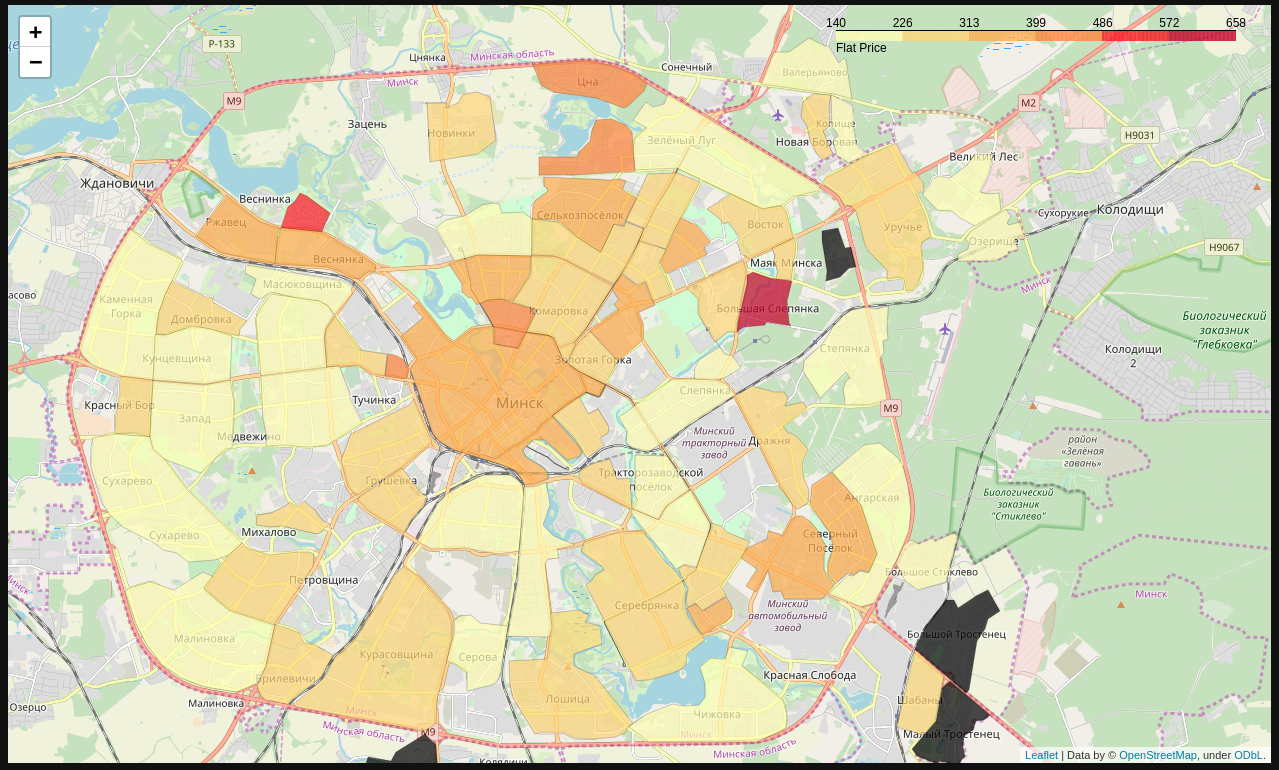

In [26]:
Image('imgs/minsk_avg_flat_price.png')

## Optional - Check flats that do not have area names (neighborhood) with combined folium map

In [22]:
# add markers to map
for lat, lng, price, flat_size, address in zip(df_flats['lat'], df_flats['lng'], df_flats['price'], df_flats['flat-size'], df_flats['address']):
    label = '{}$, {}k, {}'.format(price, flat_size, address)
    label_f = folium.Popup(label, parse_html=True)
    tooltip = folium.Tooltip(label)
    folium.CircleMarker(
        (lat, lng),
        radius=5,
        popup=label_f,
        tooltip=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_minsk_flat)  
    
map_minsk_flat

### Optional - Add new flats

In [23]:
qqq = [
    [450, 1.0, 'Небесная 1/2', 53.952924, 27.6643595],
    [350, 1.0, "Леонардо да Винчи 2", 53.9522812, 27.6656455],
    [420, 1.0, "Леонардо да Винчи 2", 53.952598, 27.6658581],
    [399, 2.0, "Леонардо да Винчи 2", 53.952598, 27.6658581],
    [380, 2.0, "Копищи, Николая Михайлашева 2", 53.9594103, 27.6696521],
    [1200, 6.0, "Валерьяново", 53.9692406, 27.661743],
    [100, 0.5, 'Ольшевского 49', 53.9231577, 27.4898139],
]

In [ ]:
for i in qqq:
    df_flats = df_flats.append(pd.Series(i, index=df_flats.columns), ignore_index=True)

df_flats.tail()

In [25]:
# df_flats.to_csv('datas/minsk_flats.csv')

# Done!